In [1]:
import numpy as np 
import pandas as pd

import random

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, roc_auc_score, plot_confusion_matrix, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

from jupyterthemes import jtplot
jtplot.style('grade3')

# Read Data

In [2]:
df = pd.read_csv('./data_for_student_case.csv')
df.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271


In [3]:
type_name, type_count = np.unique(df['simple_journal'], return_counts=True)
for i in range(len(type_name)):
    print(str(type_name[i])+':', type_count[i], '('+str(100*np.round(type_count[i]/len(df),4))+'%)')

Chargeback: 345 (0.12%)
Refused: 53346 (18.37%)
Settled: 236691 (81.51%)


# Data Preprocessing

## Delete Refused Catagory

In [4]:
df_new = df[df['simple_journal'] != 'Refused'].copy()
type_name, type_count = np.unique(df_new['simple_journal'], return_counts=True)
for i in range(len(type_name)):
    print(str(type_name[i])+':', type_count[i], '('+str(100*np.round(type_count[i]/len(df_new),4))+'%)')

Chargeback: 345 (0.15%)
Settled: 236691 (99.85000000000001%)


## CVCResponseCode Aggregation

In [5]:
df_new['cvcRes'] = df_new['cvcresponsecode'].apply(lambda x: 3 if (x >= 3 and x<6) else x)

## Data Encoding

In [6]:
# 1.label
df_new['label'] = df['simple_journal'].apply(lambda x: 1 if x == 'Chargeback' else 0)

# 2.creationdate
df_new['creationdate'] = pd.to_datetime(df_new['creationdate'])
df_new['creationdate'] = df_new['creationdate'].dt.date
date_enc = LabelEncoder()
date_enc.fit(df_new['creationdate'])
df_new['date'] = date_enc.transform(df_new['creationdate'])

# 3.txvariantcode
txc_enc = LabelEncoder()
txc_enc.fit(df_new['txvariantcode'])
df_new['txCode'] = txc_enc.transform(df_new['txvariantcode'])

# 4.issuercountrycode
issue_enc = LabelEncoder()
issue_enc.fit(df_new['issuercountrycode'].astype(str))
df_new['issuerCountry'] = issue_enc.transform(df_new['issuercountrycode'].astype(str))

# 5.accountcode
account_enc = LabelEncoder()
account_enc.fit(df_new['accountcode'])
df_new['account'] = account_enc.transform(df_new['accountcode'])

# 6.shopperinteraction
interaction_enc = LabelEncoder()
interaction_enc.fit(df_new['shopperinteraction'])
df_new['interaction'] = interaction_enc.transform(df_new['shopperinteraction'])

# 7.shoppercountrycode
shopperCountry_enc = LabelEncoder()
shopperCountry_enc.fit(df_new['shoppercountrycode'].astype(str))
df_new['shopperCountry'] = shopperCountry_enc.transform(df_new['shoppercountrycode'].astype(str))

In [7]:
# 8.converting different currency to a homogeneous value
to_euro = {
    'AUD': 0.64147,
    'GBP': 1.1494,
    'MXN': 0.04169,
    'NZD': 0.59499,
    'SEK': 0.09859
}
def amount_to_euro(df_colums):
    amount, currency = df_colums
    return to_euro[currency] * amount / 100
df_new['euroAmount'] = df_new[['amount', 'currencycode']].apply(amount_to_euro, axis=1)

In [8]:
# 9.card_id
card_enc = LabelEncoder()
card_enc.fit(df_new['card_id'])
df_new['card_id'] = card_enc.transform(df_new['card_id'])

# 10.ip_id
ip_enc = LabelEncoder()
ip_enc.fit(df_new['ip_id'])
df_new['ip_id'] = ip_enc.transform(df_new['ip_id'])

# 11.mail_id
mail_enc = LabelEncoder()
mail_enc.fit(df_new['mail_id'])
df_new['mail_id'] = mail_enc.transform(df_new['mail_id'])

## Useful Columns Extraction

In [9]:
df_trial = df_new[[
    'date', 'issuerCountry', 
    'shopperCountry', 'interaction', 'euroAmount', 'cardverificationcodesupplied', 'cvcRes', 
    'mail_id', 'ip_id', 'card_id', 'bin','txCode', 'account', 'label'
    ]].copy()

## NAN Modification

In [10]:
df_trial.loc[df_trial['cardverificationcodesupplied'].isna(),'cardverificationcodesupplied'] = False
df_trial.loc[df_trial['issuerCountry'].isna(),'issuerCountry'] = 'ZZ'
df_trial.loc[df_trial['shopperCountry'].isna(),'shopperCountry'] = 'ZZ'

print(np.where(df_trial.isna())[1]) #no NAN anymore

[]


## Data Spliting

In [11]:
df_label = df_trial['label']
df_sample = df_trial[[
    'date', 'issuerCountry', 
    'shopperCountry', 'interaction', 'euroAmount', 'cardverificationcodesupplied', 'cvcRes', 
    'mail_id', 'ip_id', 'card_id', 'bin','txCode', 'account'
    ]]

x_train, x_test, y_train, y_test = train_test_split(df_sample, df_label, test_size=0.20, shuffle=True, random_state=42)

## Resample

In [12]:
def smote(X,y):
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X, y)
    return X_res, y_res

In [13]:
x_train_unswapped, y_train_unswapped = smote(x_train, y_train)
print("After SMOTE:", np.unique(y_train_unswapped, return_counts=True))

After SMOTE: (array([0, 1], dtype=int64), array([189358, 189358], dtype=int64))


## Rank Swapping
The rank swapping alogrithm will be applied to:
- bin: card issuer identifier
- mail_id: Email address
- ip_id: Ip address
- card_id: Card number

### Implement the rank swapping algorithm.

In [14]:
def rank_swapping(df, columns, p=1):
    '''
    df: pandas dataframe
    columns: the string names of columns
    p: the swapping range p%
    replace: replace the original dataframe
    
    return: rank swapped dataframe 
    '''
    if p == 0:
        return df
    
    print("It will take "+str(p)+" neighbour(s) into consideration")
    print(str(columns) + " - Swapping Range:", str(np.round(100*p/len(df),4))+'%')
    
    df_ = df.copy()
    length = len(df_)
    
    for column in columns:
        df_.sort_values(by=column, inplace=True)
        df_.reset_index(drop=True, inplace=True)
        col_values = df_[column].copy()
        for current_index in range(0, length):
            swap_index = current_index + random.randint(-p,p)
            if swap_index > length - 1:
                swap_index = random.randint(current_index, length-1)
            elif swap_index < 0:
                swap_index = random.randint(0, current_index)
            df_.at[current_index, column], df_.at[swap_index, column] = col_values[swap_index], col_values[current_index]
            
    return df_

### Apply rank swapping algorithm

In [15]:
x_train_unswapped.head()

,date,issuerCountry,shopperCountry,interaction,euroAmount,cardverificationcodesupplied,cvcRes,mail_id,ip_id,card_id,bin,txCode,account
0,91,7,8,1,102.63520,1,0,123705,31114,160263,401795.0,8,0
1,47,96,122,1,117.32210,1,1,2173,89498,30314,453903.0,8,2
2,18,40,47,1,36.72333,1,1,204188,204483,192658,475117.0,8,3
3,38,40,47,1,51.72300,1,1,58864,136516,195673,475117.0,8,3
4,106,40,47,1,32.12573,1,1,132837,5577,8567,492181.0,8,3


In [16]:
x_train_swapped, y_train_swapped = x_train_unswapped.copy(), y_train_unswapped.copy()
x_train_swapped['temp_label'] = y_train_swapped.copy()
x_train_swapped = rank_swapping(x_train_swapped, ['bin', 'mail_id', 'ip_id', 'card_id'], p=100)
y_train_swapped = x_train_swapped['temp_label'].copy()
x_train_swapped.drop(columns=['temp_label'], inplace=True)

It will take 100 neighbour(s) into consideration
['bin', 'mail_id', 'ip_id', 'card_id'] - Swapping Range: 0.0264%


In [17]:
x_train_unswapped.head()

,date,issuerCountry,shopperCountry,interaction,euroAmount,cardverificationcodesupplied,cvcRes,mail_id,ip_id,card_id,bin,txCode,account
0,91,7,8,1,102.63520,1,0,123705,31114,160263,401795.0,8,0
1,47,96,122,1,117.32210,1,1,2173,89498,30314,453903.0,8,2
2,18,40,47,1,36.72333,1,1,204188,204483,192658,475117.0,8,3
3,38,40,47,1,51.72300,1,1,58864,136516,195673,475117.0,8,3
4,106,40,47,1,32.12573,1,1,132837,5577,8567,492181.0,8,3


In [18]:
x_train_swapped.head()

,date,issuerCountry,shopperCountry,interaction,euroAmount,cardverificationcodesupplied,cvcRes,mail_id,ip_id,card_id,bin,txCode,account
0,99,40,47,1,50.228780,0,1,148744,174938,2,465859.000000,8,3
1,107,40,47,1,92.722098,1,1,121965,11362,22,527697.151469,2,3
2,7,40,47,1,88.216450,1,1,16589,198530,33,475129.000000,8,3
3,105,40,47,1,99.066786,1,1,120698,40624,49,465901.000000,8,3
4,18,40,47,1,62.010130,1,1,204626,11630,5,465838.000000,8,3


## Train three classifiers using rank swapping/unswapping

In [19]:
def return_roc(model, x_train, y_train, x_test, y_test, normalize=True):
    if (normalize):
        scaler_norm = Normalizer().fit(x_train)
        x_train = scaler_norm.transform(x_train)
        x_test = scaler_norm.transform(x_test)
    
    model.fit(x_train, y_train)
    probs = model.predict_proba(x_test)[:, 1]
    auc = roc_auc_score(y_test, probs)
    fpr, tpr, _ = roc_curve(y_test, probs)    
    
    return fpr, tpr, auc

### Decision Tree

Unswapped AUC = 0.8557106740188312 Swapped AUC = 0.8778404073268122


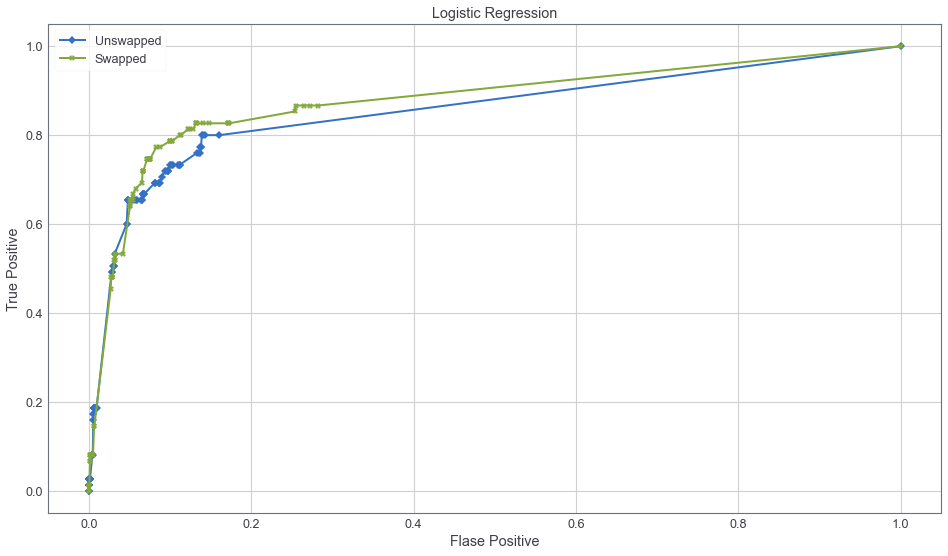

In [20]:
dt = DecisionTreeClassifier(splitter='random', max_depth=10)
plt.figure(figsize=(16,9))
unswapped_fpr, unswapped_tpr, unswapped_auc = return_roc(dt, x_train_unswapped, y_train_unswapped, x_test, y_test)
plt.plot(unswapped_fpr, unswapped_tpr, "-D", label='Unswapped', linewidth=2)
swapped_fpr, swapped_tpr, swapped_auc = return_roc(dt, x_train_swapped, y_train_swapped, x_test, y_test)
plt.plot(swapped_fpr, swapped_tpr, "-X", label='Swapped', linewidth=2)
print("Unswapped AUC =", unswapped_auc, "Swapped AUC =", swapped_auc)
plt.xlabel('Flase Positive')
plt.ylabel('True Positive')
plt.legend(['Unswapped', 'Swapped'])
plt.title("Logistic Regression")
plt.show()

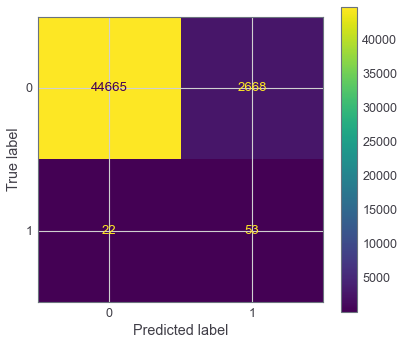

In [21]:
dt.fit(x_train_unswapped, y_train_unswapped)
plot_confusion_matrix(dt, x_test, y_test)
plt.show()

### Random Forest

Unswapped AUC = 0.8990994302776781 Swapped AUC = 0.9103164106789484


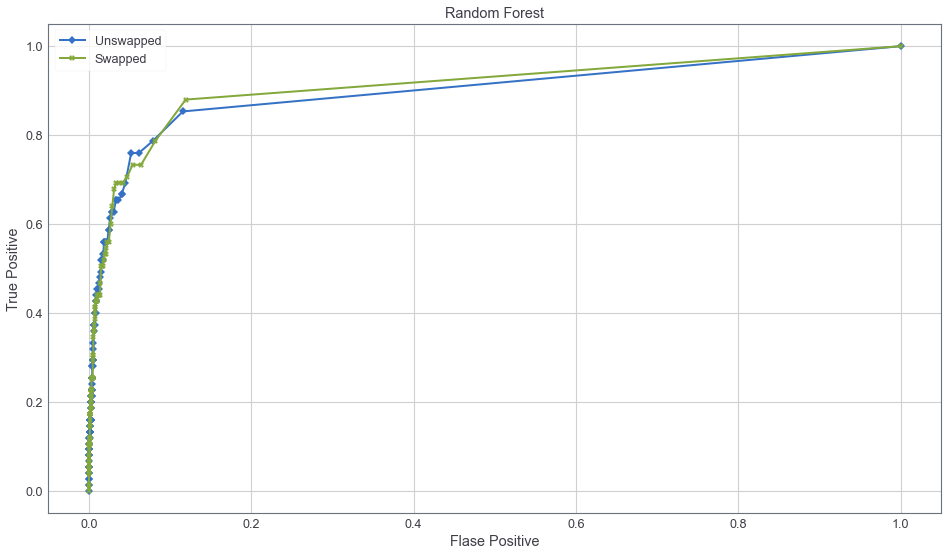

In [22]:
rf = RandomForestClassifier(n_estimators=200)
plt.figure(figsize=(16,9))
unswapped_fpr, unswapped_tpr, unswapped_auc = return_roc(rf, x_train_unswapped, y_train_unswapped, x_test, y_test, normalize=False)
plt.plot(unswapped_fpr, unswapped_tpr, "-D", label='Unswapped', linewidth=2)
swapped_fpr, swapped_tpr, swapped_auc = return_roc(rf, x_train_swapped, y_train_swapped, x_test, y_test, normalize=False)
plt.plot(swapped_fpr, swapped_tpr, "-X", label='Swapped', linewidth=2)
print("Unswapped AUC =", unswapped_auc, "Swapped AUC =", swapped_auc)
plt.xlabel('Flase Positive')
plt.ylabel('True Positive')
plt.legend(['Unswapped', 'Swapped'])
plt.title("Random Forest")
plt.show()

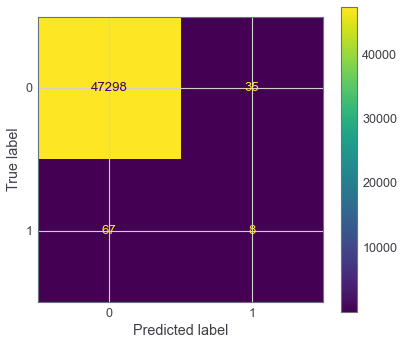

In [23]:
rf.fit(x_train_unswapped, y_train_unswapped)
plot_confusion_matrix(rf, x_test, y_test)
plt.show()

### GaussianNB


Unswapped AUC = 0.8433511503602139 Swapped AUC = 0.8433384742146073


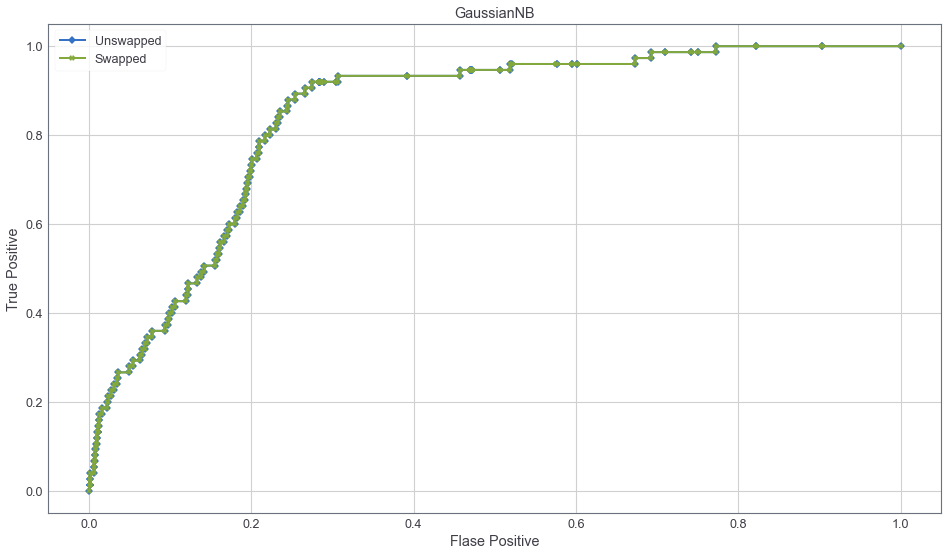

In [24]:
nb = GaussianNB()
plt.figure(figsize=(16,9))
unswapped_fpr, unswapped_tpr, unswapped_auc = return_roc(nb, x_train_unswapped, y_train_unswapped, x_test, y_test)
plt.plot(unswapped_fpr, unswapped_tpr, "-D", label='Unswapped', linewidth=2)
swapped_fpr, swapped_tpr, swapped_auc = return_roc(nb, x_train_swapped, y_train_swapped, x_test, y_test)
plt.plot(swapped_fpr, swapped_tpr, "-X", label='Swapped', linewidth=2)
print("Unswapped AUC =", unswapped_auc, "Swapped AUC =", swapped_auc)
plt.xlabel('Flase Positive')
plt.ylabel('True Positive')
plt.legend(['Unswapped', 'Swapped'])
plt.title("GaussianNB")
plt.show()

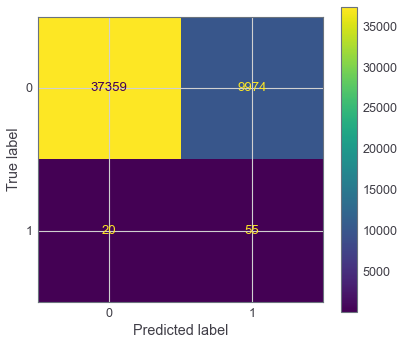

In [25]:
nb.fit(x_train_unswapped, y_train_unswapped)
plot_confusion_matrix(nb, x_test, y_test)
plt.show()